

```
# This is formatted as code
```

#  Bee Project

In [173]:

import os
from google.colab import drive
CUR_DIR = "drive/My Drive/shibumi"
drive.mount('/content/drive')
CUR_DIR = "drive/My Drive/shibumi"
os.chdir(CUR_DIR)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


FileNotFoundError: ignored

### Purpose

In this project we have set of bee images including 5 subspecies of bees and other group of bees that their subtype isn’t specified.  The purpose of this work is to classify the correct species of a certain bee using metadata information and an image of the bee. 

### Agenda
Exploring the data and relevant features for the classification task
Building a model for a bee subspecies classification using the metadata information
Building Deep Learning model using the images
Cluster Analysis





In [174]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
!pip install flashtorch 

import matplotlib.pyplot as plt
from plotnine import *

from mlxtend.plotting import plot_confusion_matrix
from flashtorch.utils import denormalize
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision

import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import imageio


from torchvision import datasets, transforms, models

*reading the metadata*

In [0]:
data = pd.read_csv('bee_data.csv')

Subspecies of Bees we have in the data

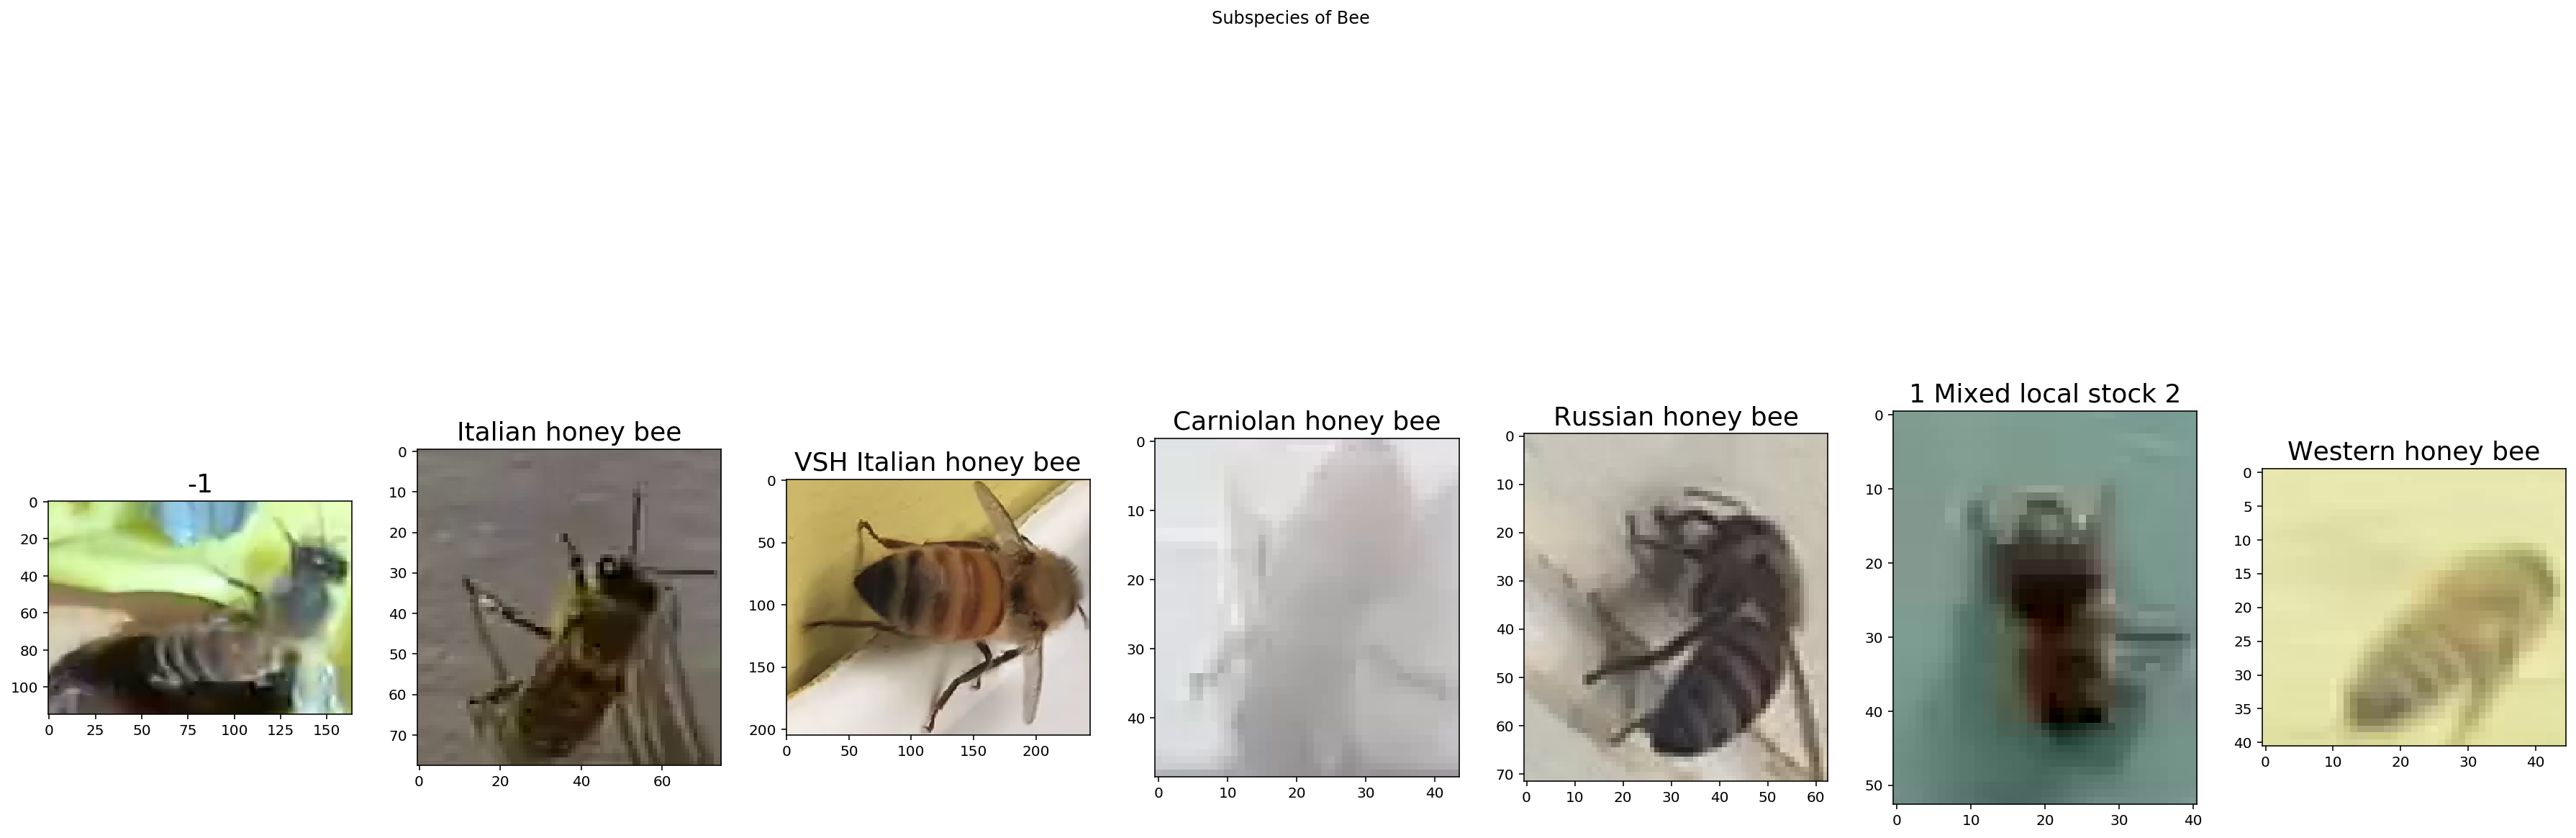

In [176]:
subspecies = data['subspecies'].unique()
f, ax = plt.subplots(nrows=1,ncols=subspecies.size, figsize=(25,12))
i=0
# Draw the first found bee of given subpecies
for s in subspecies:
    if s == 'healthy': continue
    file='bee_imgs/' + data[data['subspecies']==s].iloc[0]['file']
    im=imageio.imread(file)
    ax[i].imshow(im, resample=True)
    ax[i].set_title(s, fontsize=18)
    i+=1
    
plt.suptitle("Subspecies of Bee")
plt.tight_layout()
plt.show()

The metadata structure (first 5 rows)

In [177]:
data.head()

file     date   time  ...             health  pollen_carrying   caste
0  041_066.png  8/28/18  16:07  ...  hive being robbed            False  worker
1  041_072.png  8/28/18  16:07  ...  hive being robbed            False  worker
2  041_073.png  8/28/18  16:07  ...  hive being robbed            False  worker
3  041_067.png  8/28/18  16:07  ...  hive being robbed            False  worker
4  041_059.png  8/28/18  16:07  ...  hive being robbed            False  worker

[5 rows x 9 columns]

The following is the plot of how many of the bee from subtype represented by sum color was the documented on the date represented by the x axis. It seems that the date can tell us about the subtype since sum dates include specific subtypes and no other. So, this variable holds a relevant information for the subtype prediction task.
For understanding the causal relation between the date or maybe the month and the subtype we need to know if the subtypes were documented randomly regardless of the subtypes.
 

/usr/local/lib/python3.6/dist-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/usr/local/lib/python3.6/dist-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


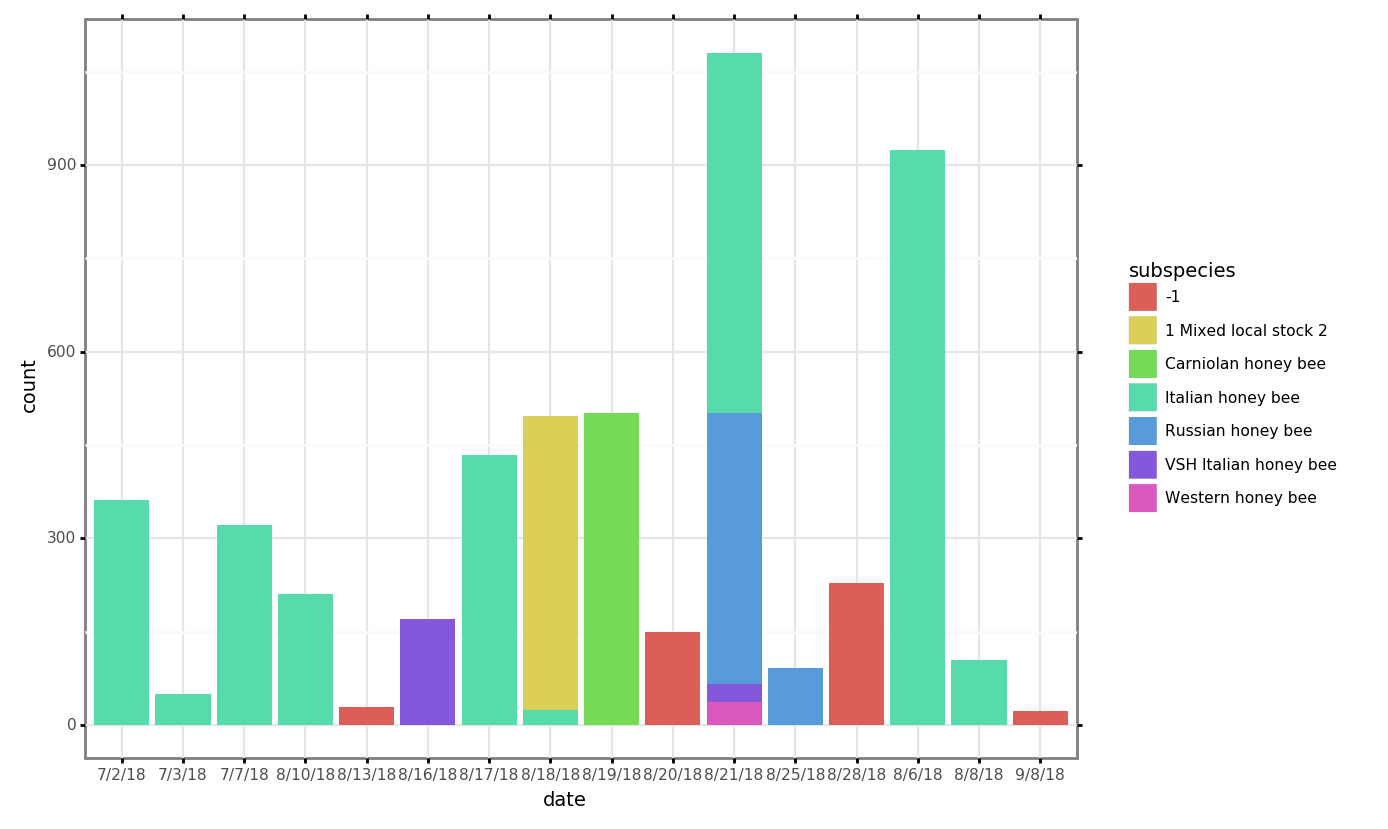

<ggplot: (8770867493275)>

In [178]:

(ggplot(data)+aes(x='date',fill='subspecies')
    +geom_bar()
    +theme_bw(base_size = 7)
    )

**Carrying pollen and subspecies**. It seems that pollen Carrying is an indication of the e Italian honey bee. Since the proportion is very small and the Italian honey bee is much more frequent. We need think about this carefully, Perhaps, if we had more samples from other bee type, we would see also other bees that are caring pollen.
The following is a table of the pollen caring trait counted separately for each subspecies.


In [179]:
crs_tab = pd.crosstab(columns=  data.pollen_carrying, index=data.subspecies,margins=True)
crs_tab

pollen_carrying        False  True   All
subspecies                              
-1                       416    12   428
1 Mixed local stock 2    472     0   472
Carniolan honey bee      501     0   501
Italian honey bee       3002     6  3008
Russian honey bee        527     0   527
VSH Italian honey bee    199     0   199
Western honey bee         37     0    37
All                     5154    18  5172

The type of illness and the subspecies seem to be connected. Hence, if a bee is sick, we will probably guess right its type. thus, making the health an important feature for the classification.

In [180]:
crs_tab = pd.crosstab(columns=  data.health, index=data.subspecies,margins=True)
crs_tab

health                 Varroa, Small Hive Beetles  ...   All
subspecies                                         ...      
-1                                              0  ...   428
1 Mixed local stock 2                         472  ...   472
Carniolan honey bee                             0  ...   501
Italian honey bee                               0  ...  3008
Russian honey bee                               0  ...   527
VSH Italian honey bee                           0  ...   199
Western honey bee                               0  ...    37
All                                           472  ...  5172

[8 rows x 7 columns]

2D Histogram Plot of the health and the subspecies features. The color is getting yellower and less pruple as count gets large. 

/usr/local/lib/python3.6/dist-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/usr/local/lib/python3.6/dist-packages/plotnine/utils.py:36: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return is_string(val) or not cbook.iterable(val)
/usr/local/lib/python3.6/dist-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


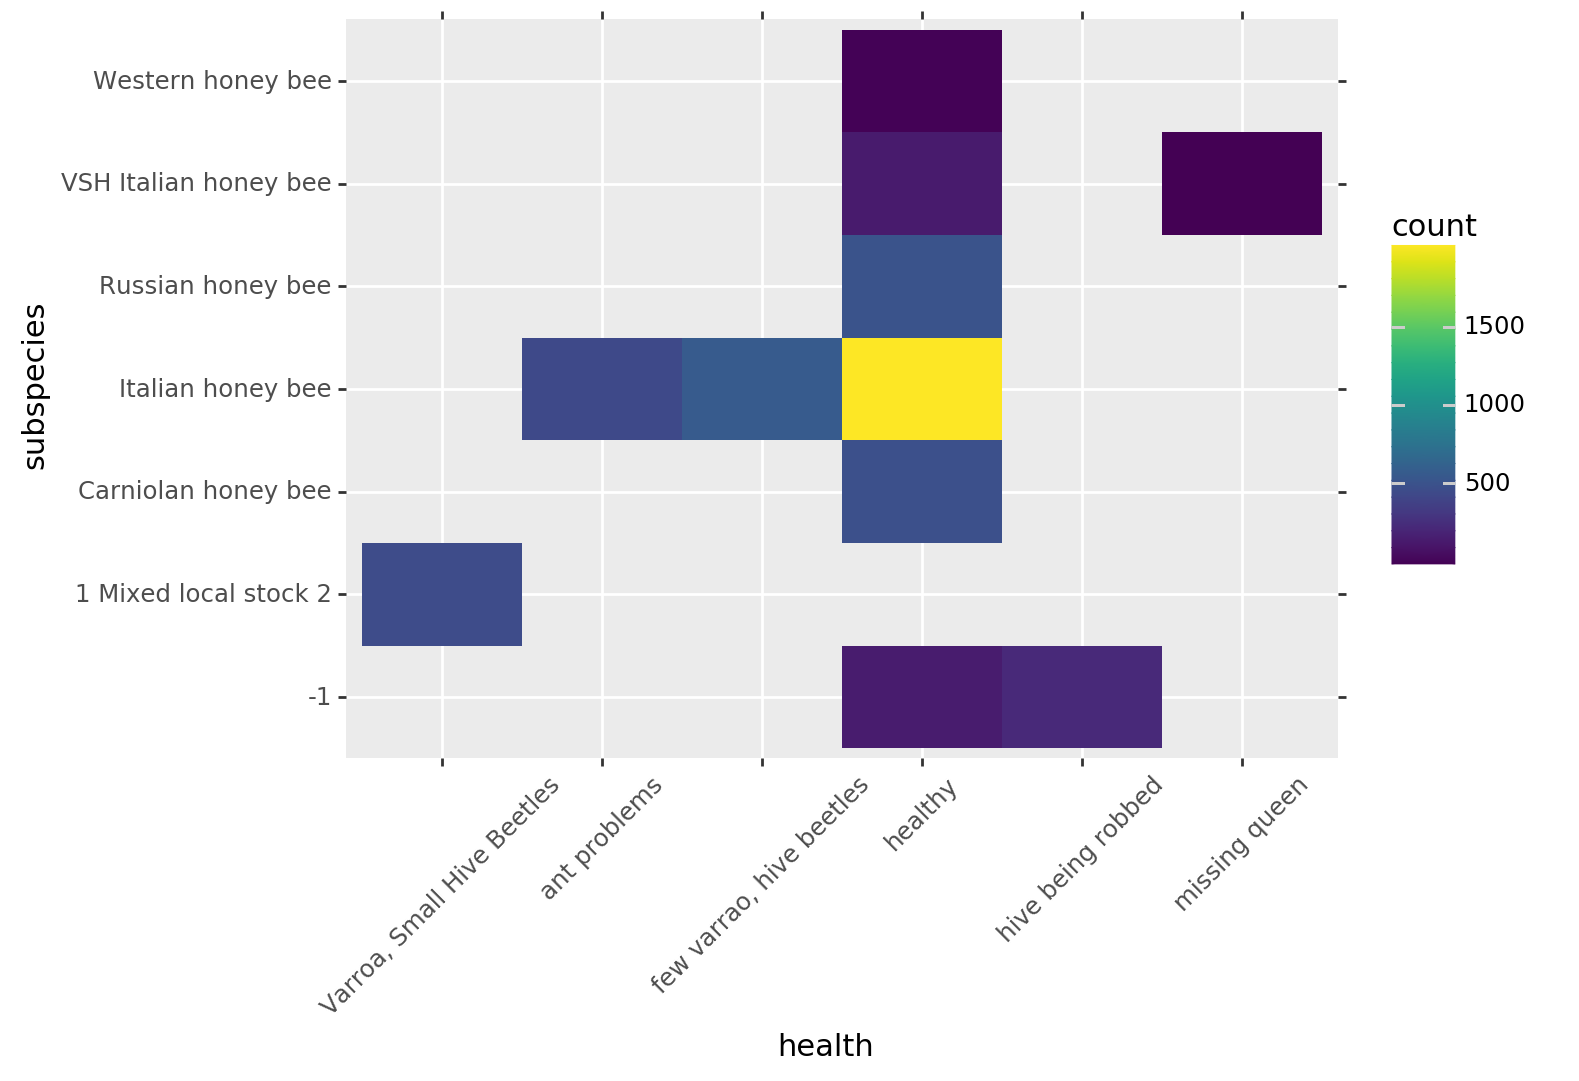

<ggplot: (-9223363265987321379)>

In [181]:
(ggplot(data)
     + aes('health', 'subspecies')
     + geom_bin2d(bins=20)
     +theme(axis_text_x=element_text(rotation=45, hjust=-1))
)

The 'caste' feature has no informaiton since there are only workers in the data

In [182]:
data_healthy = data[~data.health.isin(['healthy'])]
crs_tab = pd.crosstab( columns=  data.caste, index=data.health,margins=True)
data.caste.describe()


count       5172
unique         1
top       worker
freq        5172
Name: caste, dtype: object

The zip code and location features hold relevant information. Sum subtypes are related to a specific location. 

In [183]:
data['zip code'].value_counts()


95070    2000
30607    1051
50315     973
77511     737
70115     170
95124     149
3431       92
Name: zip code, dtype: int64

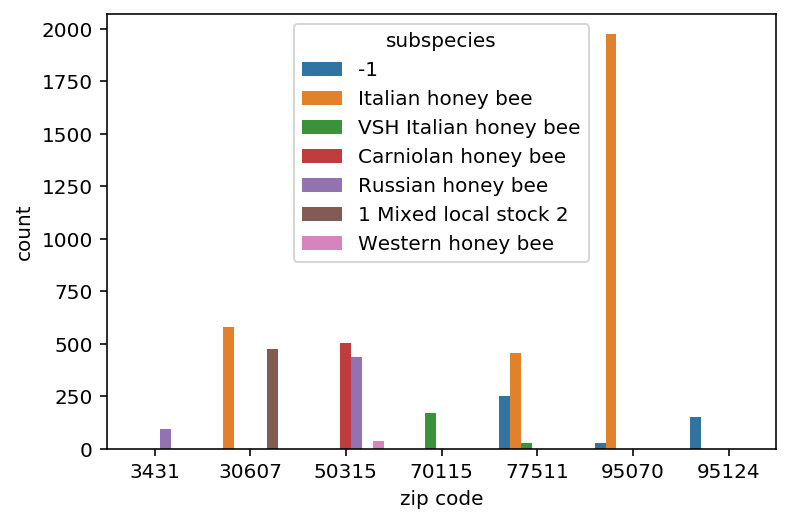

In [184]:

sns.countplot(x="zip code", hue="subspecies", data=data)

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

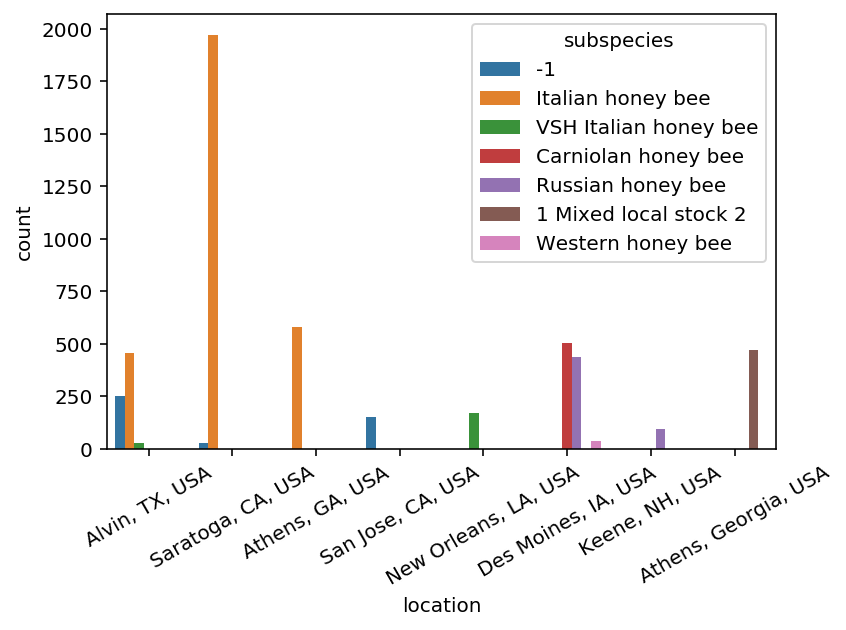

In [185]:
s=sns.countplot(x="location", hue="subspecies", data=data)
plt.xticks(rotation=30)



```
Logistic Reggression for bee subtype classification
```



In [186]:
import copy
#separating between the features and the labels
data.pollen_carrying = data.pollen_carrying.map({False:0,True:1})
df = copy.deepcopy(data[data['subspecies'] != '-1'])

df.head()

file    date   time  ...   health  pollen_carrying   caste
74  017_029.png  8/6/18  13:21  ...  healthy                0  worker
75  017_015.png  8/6/18  13:21  ...  healthy                0  worker
76  017_001.png  8/6/18  13:21  ...  healthy                0  worker
77  017_000.png  8/6/18  13:21  ...  healthy                0  worker
78  017_014.png  8/6/18  13:21  ...  healthy                0  worker

[5 rows x 9 columns]

In [0]:

#encoding the labels for the regression task
y = copy.deepcopy(df.subspecies).map({'-1':-1,
             '1 Mixed local stock 2':0,
             'Carniolan honey bee':1,
             'Italian honey bee':2,
             'Russian honey bee':3,
             'VSH Italian honey bee':4,
             'Western honey bee':5})
df = df.drop(columns = ['subspecies','caste','file'])
df['zip code'] = df['zip code'].astype(str)




Classification model and results:

In [0]:
from sklearn.model_selection import train_test_split
import copy
df = pd.get_dummies(df)
X,y = copy.deepcopy(df),copy.deepcopy(y)
X_train, X_test, y_train, y_test = train_test_split(np.asarray(X), np.asarray(y), test_size=0.2,shuffle=True)

In [189]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression(random_state=0, solver='lbfgs',
                          multi_class='multinomial')
logreg.fit(X_train, y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Given the metadata we build a model that predict accurately (100%) the subtype of the bee. See the confusion matrix below

Accuracy of logistic regression classifier on test set: 1.00


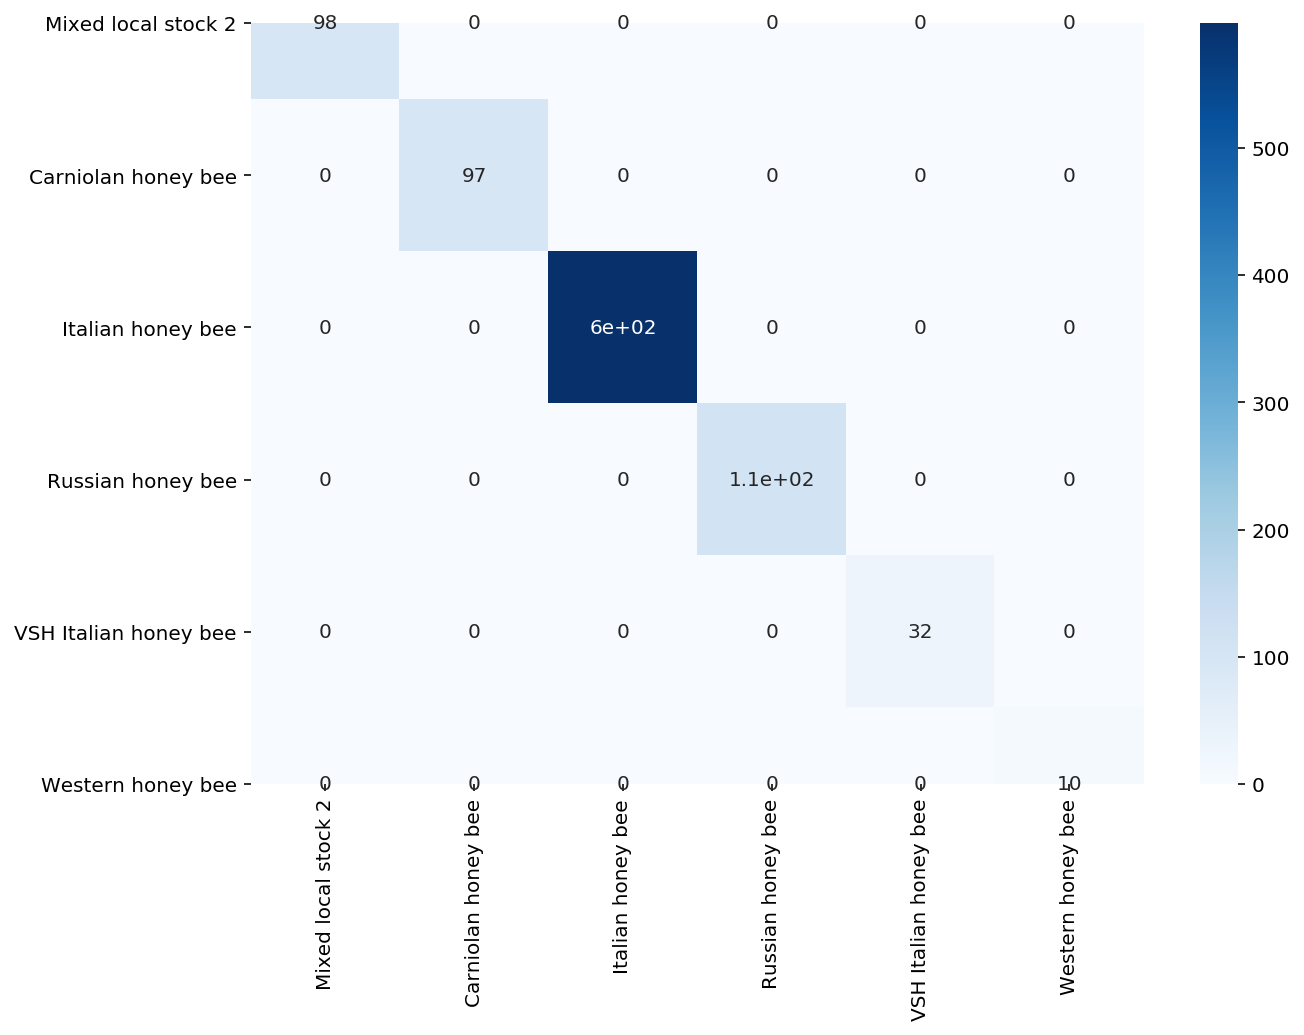

In [190]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_pred,y_test)
class_names= ['Mixed local stock 2',
             'Carniolan honey bee',
             'Italian honey bee',
             'Russian honey bee',
             'VSH Italian honey bee',
             'Western honey bee']

df_cm = pd.DataFrame(cnf_matrix, index = [i for i in class_names],
                  columns = [i for i in class_names])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, cmap ='Blues',)
                      
plt.show()

Training A neural net


In [0]:
from torch.utils.data import Dataset, dataloader
#data loaders
class Bee_data(Dataset):
    """BEE dataset."""

    def __init__(self, csv_file, root_dir, metadata = None, transform=None):
        """
        
        """
        self.labels_col = 5 
        self.dataset = pd.read_csv(csv_file)
        self.dataset.subspecies =   self.dataset.subspecies.map({'-1':-1,
             '1 Mixed local stock 2':0,
             'Carniolan honey bee':1,
             'Italian honey bee':2,
             'Russian honey bee':3,
             'VSH Italian honey bee':4,
             'Western honey bee':5})
        self.dataset = self.dataset[self.dataset.subspecies != -1]
        self.root_dir = root_dir
        self.labels = np.asarray(self.dataset.subspecies)
        self.transform = transform
        self.metadata = metadata
       

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        imgs_name = os.path.join(self.root_dir,
                                self.dataset.iloc[idx, 0])
        images = Image.open(imgs_name)
        images = images.convert('RGB')
        labels = self.labels[idx]

        if self.transform:
            images = self.transform(images)
        if not type(self.metadata) == None:
        
            return images,labels, torch.Tensor(np.asarray( self.metadata.iloc[idx, :]))
        
        return images,labels

In [0]:
data_dir = 'bee_imgs'
#picture transformation pipline

test_transform = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                         [0.229, 0.224, 0.225])])

full_dataset = Bee_data('bee_data.csv', 'bee_imgs',df, transform = test_transform)
train_size, test_size = len(full_dataset)-len(full_dataset)//5,len(full_dataset)//5
train_data, test_data = torch.utils.data.random_split(full_dataset, [train_size, test_size])



In [0]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=32)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32)

In [0]:
device =  torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Taking a glimpse on the images

I will use pretrained resnet network. Replaceing the classifier In last layers and training a new one instead.

In [195]:
#defineing the model and moving data to the gpu (if availble)


print(device)
model = models.resnet18(pretrained=True)


    
#building classifier
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

from collections import OrderedDict
fc = nn.Sequential(OrderedDict([
                          ('fc2', nn.Linear(512, 6)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.fc = fc
                                

criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)

model.to(device);

cuda:0


Training with one epoch only (It looks sufficiently enough for convergence of the test loss)

In [196]:
epochs = 1
steps = 0
previous_test_loss = 999
diff = .001
running_loss = 0
print_every = 5

train_losses, test_losses = [], []
for epoch in range(epochs):
    for inputs, labels,metadata in trainloader:
        steps += 1
        
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels,metadata in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
           
            
            previous_test_loss = test_loss
            model.train()

Epoch 1/1.. Train loss: 1.304.. Test loss: 1.097.. Test accuracy: 0.611
Epoch 1/1.. Train loss: 0.863.. Test loss: 0.836.. Test accuracy: 0.757
Epoch 1/1.. Train loss: 0.881.. Test loss: 0.761.. Test accuracy: 0.734
Epoch 1/1.. Train loss: 0.686.. Test loss: 0.779.. Test accuracy: 0.756
Epoch 1/1.. Train loss: 0.660.. Test loss: 0.561.. Test accuracy: 0.814
Epoch 1/1.. Train loss: 0.458.. Test loss: 0.513.. Test accuracy: 0.850
Epoch 1/1.. Train loss: 0.518.. Test loss: 0.498.. Test accuracy: 0.844
Epoch 1/1.. Train loss: 0.414.. Test loss: 0.437.. Test accuracy: 0.844
Epoch 1/1.. Train loss: 0.432.. Test loss: 0.398.. Test accuracy: 0.866
Epoch 1/1.. Train loss: 0.473.. Test loss: 0.426.. Test accuracy: 0.870
Epoch 1/1.. Train loss: 0.472.. Test loss: 0.350.. Test accuracy: 0.859
Epoch 1/1.. Train loss: 0.368.. Test loss: 0.330.. Test accuracy: 0.867
Epoch 1/1.. Train loss: 0.315.. Test loss: 0.322.. Test accuracy: 0.885
Epoch 1/1.. Train loss: 0.372.. Test loss: 0.315.. Test accuracy

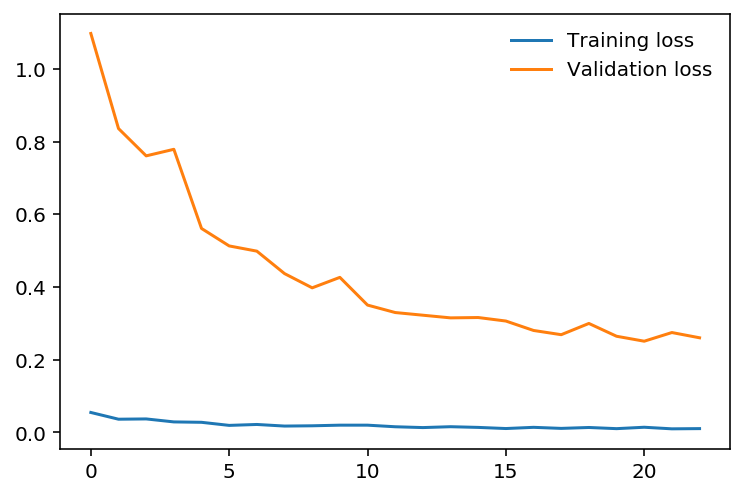

In [197]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

Visualsing the things that makes the Neural net to recognize a bee by occlusion analysis

In [0]:
dataiter = iter(trainloader)
images, labels,_ = dataiter.next()
image,label = images[0,:,:,:],labels[0]

In [199]:
image.shape

torch.Size([3, 224, 224])

In [0]:
def occlusion(model, image, label, occ_size = 20, occ_stride = 20, occ_pixel = 1):
  
    #get the width and height of the image
    width, height = image.shape[-2], image.shape[-1]
  
    #setting the output image width and height
    output_height = int(np.ceil((height-occ_size)/occ_stride))
    output_width = int(np.ceil((width-occ_size)/occ_stride))
  
    #create a white image of sizes we defined
    heatmap = torch.zeros((output_height, output_width))
    
    #iterate all the pixels in each column
    for h in range(0, height):
        for w in range(0, width):
            
            h_start = h*occ_stride
            w_start = w*occ_stride
            h_end = min(height, h_start + occ_size)
            w_end = min(width, w_start + occ_size)
            
            if (w_end) >= width or (h_end) >= height:
                continue
            
            input_image = image.detach().clone()
            
            #replacing all the pixel information in the image with occ_pixel(grey) in the specified location
            input_image[:, :, w_start:w_end, h_start:h_end] = occ_pixel
            
            #run inference on modified image
            output = model(input_image)
            output = torch.exp(output)
            prob = output.tolist()[0][label]
            
            #setting the heatmap location to probability value
            heatmap[h, w] = prob

    return heatmap


Text(0.5, 1.0, 'VSH Italian honey bee')

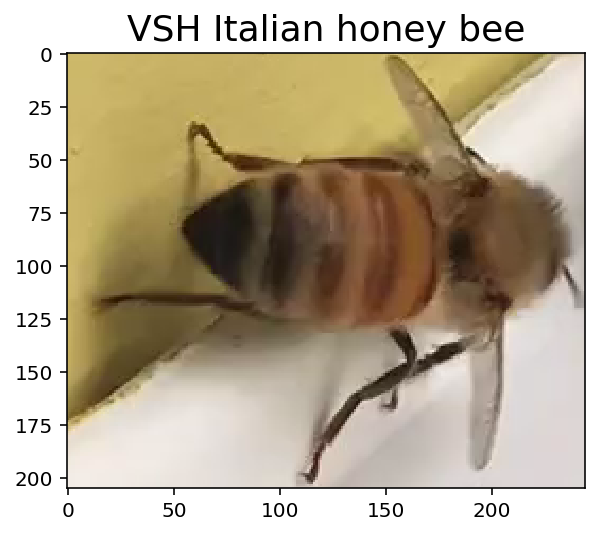

In [201]:
fig,ax = plt.subplots()
file='bee_imgs/' + data[data['subspecies']=='VSH Italian honey bee'].iloc[0]['file']
im=imageio.imread(file)
ax.imshow(im, resample=True)
ax.set_title('VSH Italian honey bee', fontsize=18)

In [203]:
img_torch = torch.Tensor(img.transpose()).cuda().unsqueeze(0)


torch.Size([1, 3, 224, 224])

In [0]:

prob_no_occ, pred = torch.max(torch.exp(model(img_torch)), 1)
heatmap = occlusion(model.cpu(), img_torch.cpu() ,label.item())

In [0]:
image = img_torch.squeeze(0).cpu().numpy().transpose((1, 2, 0))
ax.imshow(im, resample=True)
ax.set_title('VSH Italian honey bee', fontsize=18)

As one can see the heatmap on top of a given bee image emphasises the bee body

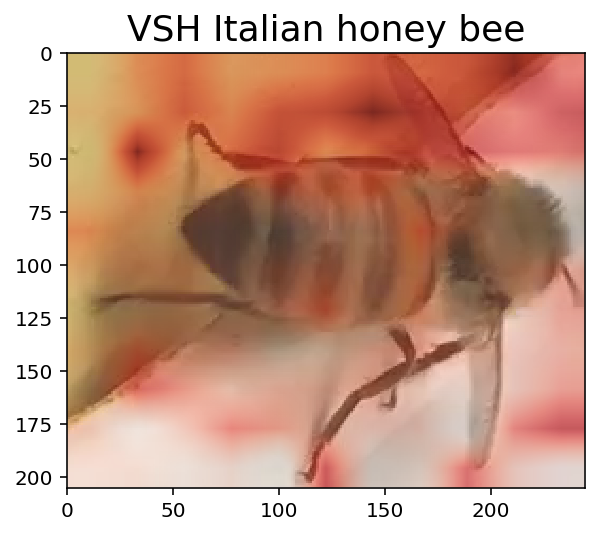

In [208]:
fig,ax = plt.subplots()
ax.imshow(im, resample=True)
ax.set_title('VSH Italian honey bee', fontsize=18)
ax.imshow(heatmap,alpha = 1,extent=(0,im.shape[1],im.shape[0],0), interpolation='bilinear',cmap=mycmap)

*Clustering* I will to use this opportunity to see how much a pretrained model is really separating the data. One could be doing a straightforward clustering on the image data. However, using CNN output has the advantage of redundant form - the output vectors for each Bee image are much smaller and therefore requiring less memory and computation complexity while performing the clustering task. In addition, the CNN is in fact succeeding in separating the data despite the nonlinearities patterns.

Loading the data and downloading the pretrained alexnet this time


In [0]:

dataloader = torch.utils.data.DataLoader(full_dataset, batch_size=128)
model = models.alexnet(pretrained=True)
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [0]:
#
outputs,labels =[],[]
batch_ii = 0
with torch.no_grad():
  for inputs, lab,_ in dataloader:
      batch_ii += 1
      print(batch_ii)
      inputs = inputs.to(device)
      out = model.forward(inputs).to(torch.device('cpu'))
      labels.append(lab)
      outputs.append(out)
labels = [lab for _,lab,_ in dataloader]


Applying kmeans on the network output. Kmeans will give us 6 vectors with 4744 entries. Each one represents a typical subtype. I will try to see what is the most common (mode) subtype in each cluster and see if fits the ground truce for the bees in the cluster. In this way I will get an "accuracy" metric.
Notice that for visualizing the quality of separation made by Network one can use the tSNE technique which project the output data of the network to a lower dimension while close bees in the higher dimension are most likely to be close in the lower one.


In [0]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6, random_state=0)
clusters = kmeans.fit_predict(out.numpy())
kmeans.cluster_centers_.shape

(6, 1000)

In [0]:
out = torch.cat(outputs)
targets = torch.cat(labels)


Calcualting the Accuracy. which is 72.7 % 

In [0]:
from scipy.stats import mode
labels = np.zeros_like(clusters)
for i in range(6):
    mask = (clusters == i)
    labels[mask] = mode(targets[mask])[0]


In [0]:
from sklearn.metrics import accuracy_score
accuracy_score(targets, labels)

0.7276559865092749

We can visualise the result by projecting the output to a lower dimension using PCA.

In [0]:

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(out.numpy())



In [0]:

labels_encode    =  { 0:'1 Mixed local stock 2',
             1:'Carniolan honey bee',
             2:'Italian honey bee',
             3:'Russian honey bee',
             4:'VSH Italian honey bee',
             5:'Western honey bee'}

The follwoing plot is a lower dimension pca projection of the net ouput. I seems that there is a separation but for example the italian honey bee and the mixed local stock are not well separated. Maybe it has to do with name (mixed).

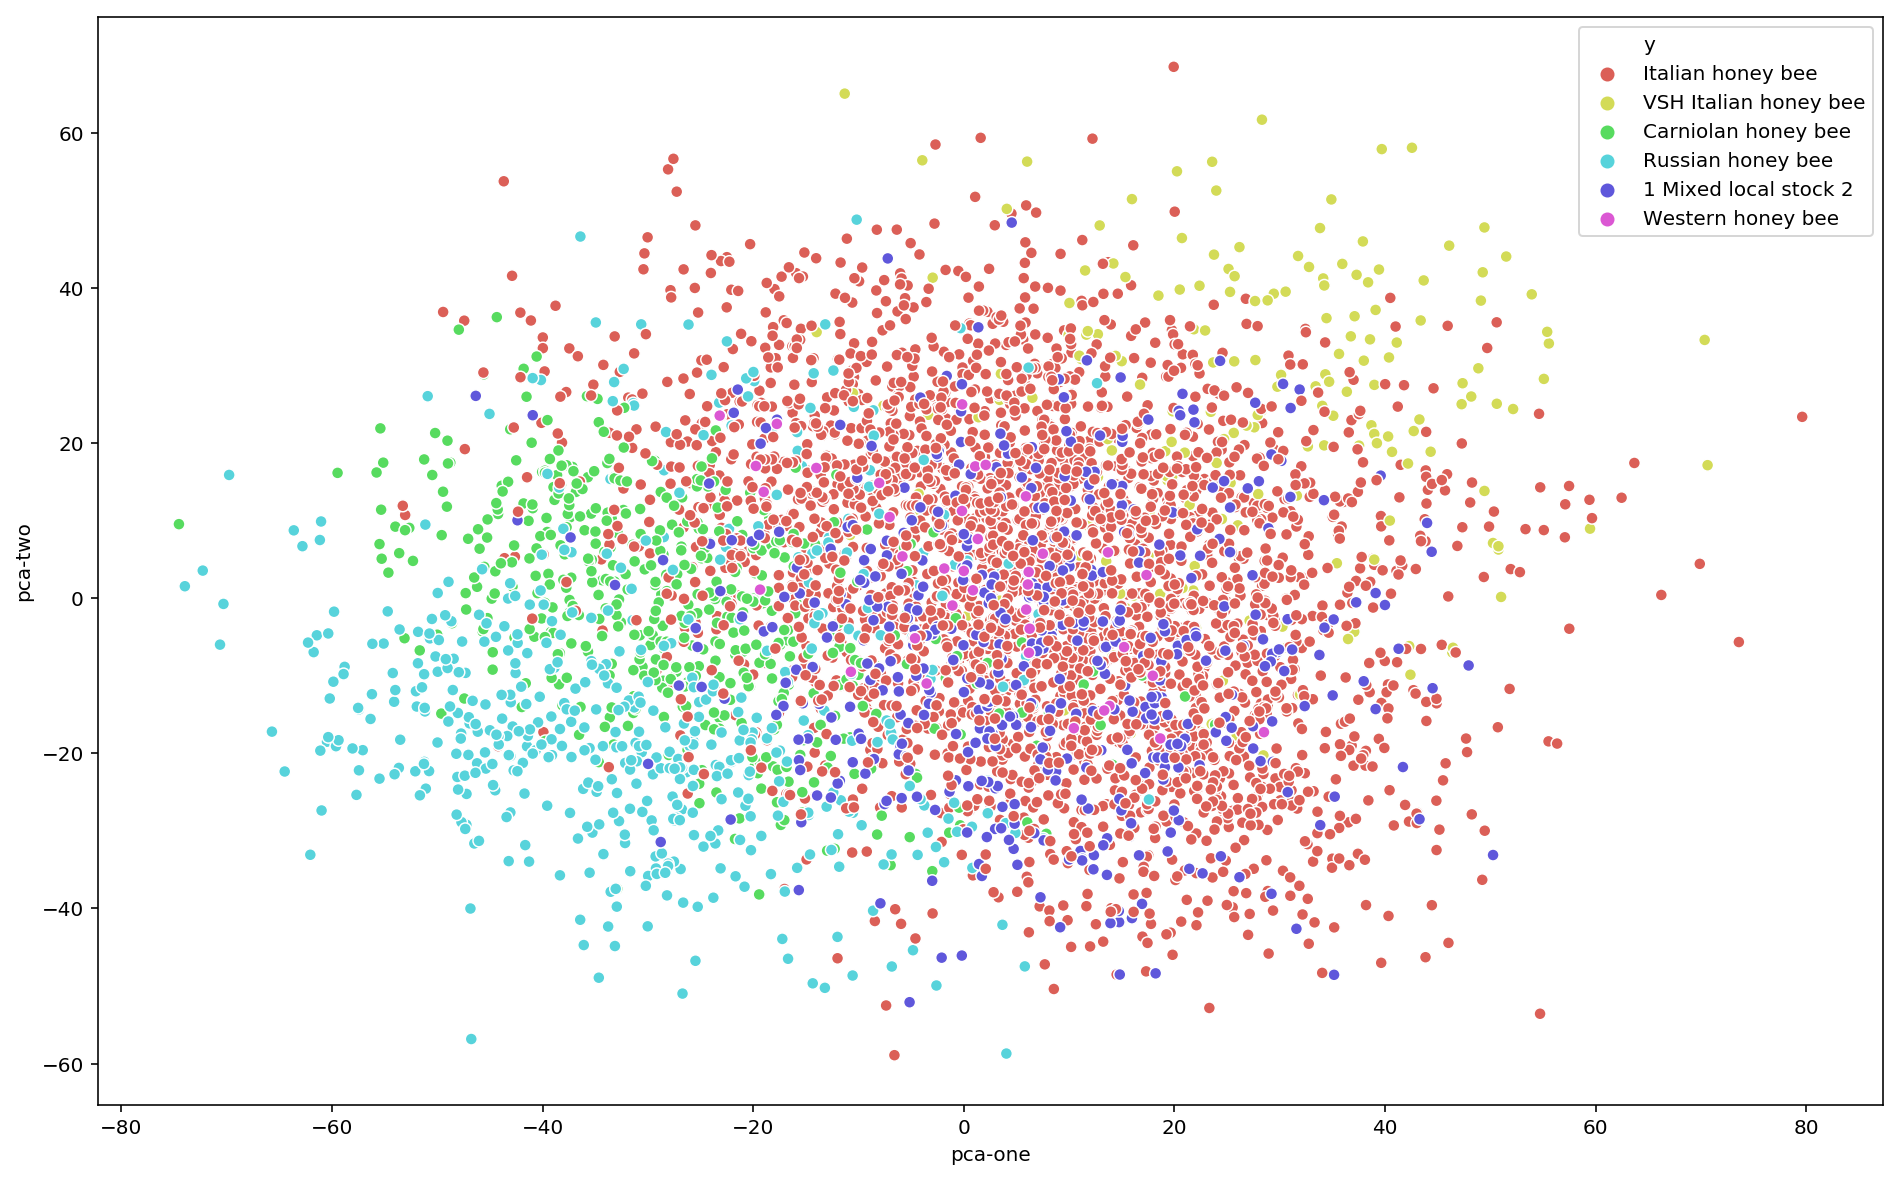

In [0]:
plt.figure(figsize=(16,10))
df = pd.DataFrame({"pca-one":pca_result[:,0],"pca-two":pca_result[:,1],"y":targets.squeeze()})
df['y'] = df.y.map(labels_encode)
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 6),
    data=df,
    legend="full"
)